In [1]:
# imports

from pathlib import Path
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor
from rich.console import Console
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

console = Console()

device = "cuda" if torch.cuda.is_available() else "cpu"
console.print(f"[bold green]Using device:[/bold green] {device}")

PROJECT_ROOT = Path("../").resolve()

VAL_CSV = PROJECT_ROOT / "data" / "processed" / "coco_val_full.csv"
CHECKPOINT_PATH = PROJECT_ROOT / "checkpoints_full" / "best_model.pt"

assert VAL_CSV.exists(), "Validation CSV not found."
assert CHECKPOINT_PATH.exists(), "Fine-tuned checkpoint not found."

/home/saber/Wox/ANLP/multimodal_ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

In [2]:
# load val data

df = pd.read_csv(VAL_CSV)

console.print(f"[bold cyan]Validation samples:[/bold cyan] {len(df)}")

# Optional: evaluate on subset first (faster debugging)
# df = df.sample(3000, random_state=42).reset_index(drop=True)


Validation samples: 41399

In [ ]:
# embeddings

def compute_embeddings(model, processor, dataframe):
    model.eval()
    image_embeddings = []
    text_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(len(dataframe))):
            row = dataframe.iloc[i]
            image = Image.open(row["image_path"]).convert("RGB")
            caption = row["caption"]

            inputs = processor(
                text=[caption],
                images=[image],
                return_tensors="pt",
                padding=True
            ).to(device)

            outputs = model(**inputs)

            image_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds

            image_embeddings.append(image_embeds.cpu())
            text_embeddings.append(text_embeds.cpu())

    image_embeddings = torch.cat(image_embeddings)
    text_embeddings = torch.cat(text_embeddings)

    # Normalize embeddings
    image_embeddings /= image_embeddings.norm(dim=1, keepdim=True)
    text_embeddings /= text_embeddings.norm(dim=1, keepdim=True)

    return image_embeddings, text_embeddings

In [5]:
# retrieval metrics

def recall_at_k(similarity, k):
    correct = 0
    for i in range(len(similarity)):
        if i in similarity[i].topk(k).indices:
            correct += 1
    return correct / len(similarity)


def mean_reciprocal_rank(similarity):
    reciprocal_ranks = []
    for i in range(len(similarity)):
        sorted_indices = similarity[i].argsort(descending=True)
        rank = (sorted_indices == i).nonzero(as_tuple=True)[0].item() + 1
        reciprocal_ranks.append(1 / rank)
    return np.mean(reciprocal_ranks)

In [6]:
# Evaluate baseline CLIP

console.print("[bold cyan]Evaluating PRETRAINED CLIP[/bold cyan]")

pretrained_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_safetensors=True
).to(device)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

img_emb_pre, txt_emb_pre = compute_embeddings(pretrained_model, processor, df)

similarity_pre = img_emb_pre @ txt_emb_pre.T

pre_metrics = {
    "Recall@1": recall_at_k(similarity_pre, 1),
    "Recall@5": recall_at_k(similarity_pre, 5),
    "Recall@10": recall_at_k(similarity_pre, 10),
    "MRR": mean_reciprocal_rank(similarity_pre)
}

pre_metrics

Evaluating PRETRAINED CLIP

Loading weights: 100%|██████████| 398/398 [00:00<00:00, 1561.62it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
100%|██████████| 41399/41399 [07:38<00:00, 90.39it/s] 


{'Recall@1': 0.08809391531196406,
 'Recall@5': 0.2905625739752168,
 'Recall@10': 0.39005773086306433,
 'MRR': np.float64(0.18618550906582243)}

In [7]:
# Evaluate fine-tuned CLIP

console.print("\n[bold yellow]Evaluating FINE-TUNED FULL CLIP[/bold yellow]")

# Load base model
finetuned_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_safetensors=True
)

# Recreate LoRA structure
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none"
)

finetuned_model.text_model = get_peft_model(
    finetuned_model.text_model,
    peft_config
)

# Load trained weights
state_dict = torch.load(CHECKPOINT_PATH, map_location=device)
finetuned_model.load_state_dict(state_dict)

finetuned_model.to(device)
finetuned_model.eval()

img_emb_ft, txt_emb_ft = compute_embeddings(finetuned_model, processor, df)

similarity_ft = img_emb_ft @ txt_emb_ft.T

ft_metrics = {
    "Recall@1": recall_at_k(similarity_ft, 1),
    "Recall@5": recall_at_k(similarity_ft, 5),
    "Recall@10": recall_at_k(similarity_ft, 10),
    "MRR": mean_reciprocal_rank(similarity_ft)
}

ft_metrics

Evaluating FINE-TUNED FULL CLIP

Loading weights: 100%|██████████| 398/398 [00:00<00:00, 2110.35it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 41399/41399 [08:48<00:00, 78.38it/s]


{'Recall@1': 0.10079953622068166,
 'Recall@5': 0.35029831638445375,
 'Recall@10': 0.46747505978405274,
 'MRR': np.float64(0.217542254850666)}

In [8]:
# Compare results

results_df = pd.DataFrame({
    "Model": ["Pretrained", "Fine-tuned Full"],
    "Recall@1": [pre_metrics["Recall@1"], ft_metrics["Recall@1"]],
    "Recall@5": [pre_metrics["Recall@5"], ft_metrics["Recall@5"]],
    "Recall@10": [pre_metrics["Recall@10"], ft_metrics["Recall@10"]],
    "MRR": [pre_metrics["MRR"], ft_metrics["MRR"]]
})

results_df

,Model,Recall@1,Recall@5,Recall@10,MRR
0,Pretrained,0.088094,0.290563,0.390058,0.186186
1,Fine-tuned Full,0.100800,0.350298,0.467475,0.217542


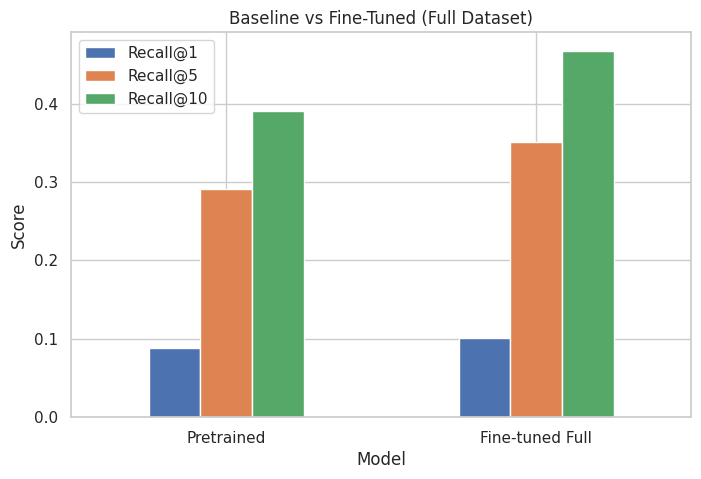

In [9]:
# Visualize comparison

sns.set(style="whitegrid")
results_df.set_index("Model")[["Recall@1", "Recall@5", "Recall@10"]].plot(
    kind="bar",
    figsize=(8,5)
)
plt.title("Baseline vs Fine-Tuned (Full Dataset)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()